# GTI DIRINT Examples

This notebook shows a few examples of the pvlib python implementation of the GTI DIRINT algorithm.

Authors: Will Holmgren (@wholmgren), University of Arizona (2017, 2018).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 8, 5
mpl.rcParams['figure.dpi'] = 100

import pandas as pd
import numpy as np

import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain
from pvlib.tracking import SingleAxisTracker
from pvlib.tools import cosd

pvlib.__version__

'0.5.2+52.g2112825'

Use a clear sky algorithm to generate some POA data.

In [2]:
times = pd.DatetimeIndex(start='20160606', end='20160607', tz='America/Phoenix', freq='1min')

In [3]:
location = Location(32.2, -110.9, altitude=700)

In [4]:
pressure = pvlib.atmosphere.alt2pres(location.altitude)

In [5]:
solpos = location.get_solarposition(times)

In [6]:
cs = location.get_clearsky(times, solar_position=solpos)

In [7]:
dni, ghi, dhi = cs['dni'], cs['ghi'], cs['dhi']

In [8]:
solar_zenith, solar_azimuth = solpos['zenith'], solpos['azimuth']

In [9]:
surface_tilt = 40
surface_azimuth = 180
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth)

In [10]:
aoi = system.get_aoi(solar_zenith, solar_azimuth)

In [11]:
# note that this method will use the haydavies transposition model by default,
# however the gti_dirint function will use perez by default.
all_irrad = system.get_irradiance(solar_zenith, solar_azimuth, dni, ghi, dhi)

In [12]:
poa_global = all_irrad['poa_global']

Text(0,0.5,'AOI (deg)')

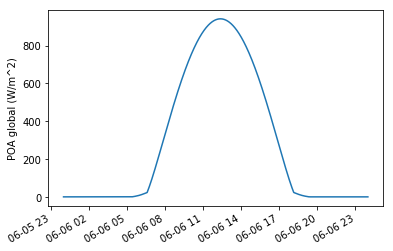

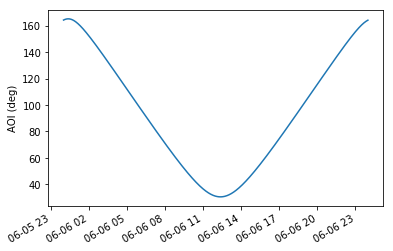

In [13]:
poa_global.plot()
plt.ylabel('POA global (W/m^2)')

plt.figure()
aoi.plot()
plt.ylabel('AOI (deg)')

In [14]:
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global, aoi, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth,
    pressure=pressure,
    use_delta_kt_prime=True, temp_dew=None, albedo=.25,
    model='perez', model_perez='allsitescomposite1990',
    calculate_gt_90=True, max_iterations=30)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1740: RuntimeWarning: 39 points failed to converge after 30 iterations.best_diff:
2016-06-06 06:36:00-07:00      16.352876
2016-06-06 06:37:00-07:00      19.110239
2016-06-06 06:38:00-07:00      21.905613
2016-06-06 06:39:00-07:00    9999.000000
2016-06-06 06:40:00-07:00      20.551082
2016-06-06 06:42:00-07:00       3.859973
2016-06-06 06:43:00-07:00       9.003798
2016-06-06 06:44:00-07:00       5.161973
2016-06-06 06:45:00-07:00       3.911216
2016-06-06 06:46:00-07:00      10.626841
2016-06-06 06:47:00-07:00       1.516607
2016-06-06 06:48:00-07:00       1.162049
2016-06-06 06:50:00-07:00       1.176532
2016-06-06 06:51:00-07:00       2.113100
2016-06-06 06:52:00-07:00       1.844274
2016-06-06 06:53:00-07:00       1.648745
2016-06-06 07:12:00-07:00       2.324358
2016-06-06 07:13:00-07:00       2.216094
2016-06-06 07:14:00-07:00       1.095382
2016-06-06 07:21:00-07:00       1.049862
2016-06-06 17:31:00-07:00       

In [15]:
color = ['b', 'g', 'r']

Text(0.5,1,'GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

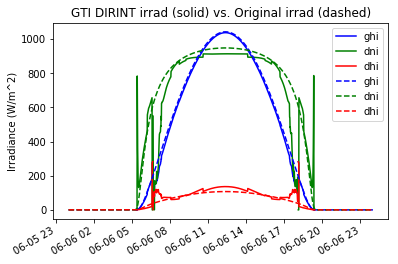

In [16]:
fig, ax = plt.subplots()
gti_dirint_out.plot(ax=ax, color=color)
cs.plot(ax=ax, ls='--', color=color)
ax.set_ylabel('Irradiance (W/m^2)')
ax.set_title('GTI DIRINT irrad (solid) vs. Original irrad (dashed)')

Repeat for summer solstice, fall equinox, winter solstice.

In [17]:
times_jun = pd.DatetimeIndex(start='20160621', end='20160622', tz='America/Phoenix', freq='1min')
times_sep = pd.DatetimeIndex(start='20160921', end='20160922', tz='America/Phoenix', freq='1min')
times_dec = pd.DatetimeIndex(start='20161221', end='20161222', tz='America/Phoenix', freq='1min')

times = times_jun.append(times_sep).append(times_dec)

In [18]:
solpos = location.get_solarposition(times)

In [19]:
cs = location.get_clearsky(times, solar_position=solpos)

In [20]:
dni, ghi, dhi = cs['dni'], cs['ghi'], cs['dhi']

In [21]:
solar_zenith, solar_azimuth = solpos['zenith'], solpos['azimuth']

In [22]:
surface_tilt = 40
surface_azimuth = 180
system = PVSystem(surface_tilt=surface_tilt, surface_azimuth=surface_azimuth)

In [23]:
aoi = system.get_aoi(solar_zenith, solar_azimuth)

In [24]:
# note that this method will use the haydavies transposition model by default,
# however the gti_dirint function will use perez by default.
all_irrad = system.get_irradiance(solar_zenith, solar_azimuth, dni, ghi, dhi)

In [25]:
poa_global = all_irrad['poa_global']

In [26]:
aoi_lt_90 = aoi < 90

In [27]:
gti_dirint_out = pvlib.irradiance.gti_dirint(
    poa_global, aoi, solar_zenith, solar_azimuth,
    times, surface_tilt, surface_azimuth,
    pressure=pressure,
    use_delta_kt_prime=True, temp_dew=None, albedo=.25,
    model='perez', model_perez='allsitescomposite1990',
    calculate_gt_90=True, max_iterations=30)

/Users/holmgren/git_repos/pvlib2/pvlib-python/pvlib/irradiance.py:1740: RuntimeWarning: 300 points failed to converge after 30 iterations.best_diff:
2016-06-21 06:40:00-07:00      18.912061
2016-06-21 06:41:00-07:00      21.652270
2016-06-21 06:42:00-07:00      24.428692
2016-06-21 06:43:00-07:00    9999.000000
2016-06-21 06:44:00-07:00       1.922856
2016-06-21 06:46:00-07:00      10.214411
2016-06-21 06:47:00-07:00       7.805079
2016-06-21 06:48:00-07:00       7.054498
2016-06-21 06:49:00-07:00       5.532489
2016-06-21 06:50:00-07:00       4.054362
2016-06-21 06:51:00-07:00       2.976889
2016-06-21 06:52:00-07:00       1.812727
2016-06-21 06:53:00-07:00       2.330492
2016-06-21 06:55:00-07:00       1.652217
2016-06-21 06:56:00-07:00       3.113023
2016-06-21 06:57:00-07:00       2.621278
2016-06-21 06:58:00-07:00       2.813203
2016-06-21 07:16:00-07:00       2.364991
2016-06-21 07:17:00-07:00       2.405483
2016-06-21 07:18:00-07:00       1.283967
2016-06-21 07:25:00-07:00      

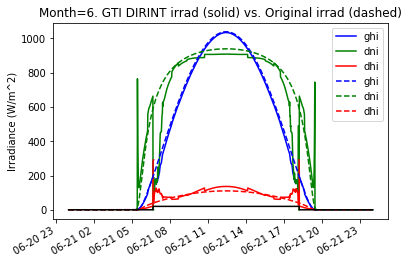

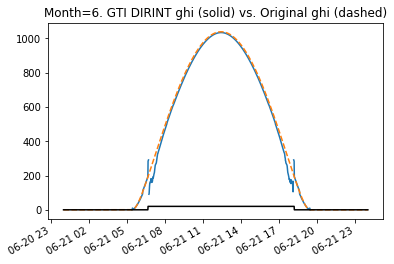

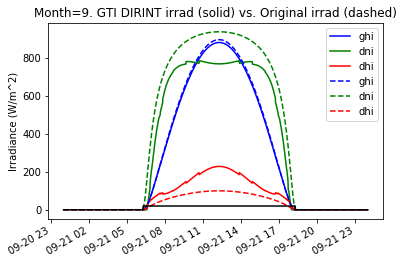

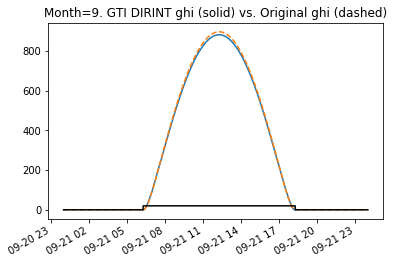

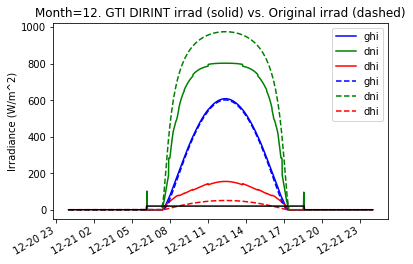

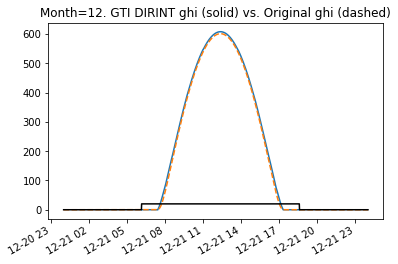

In [28]:
for month, data in gti_dirint_out.groupby(times.month):
    fig, ax = plt.subplots()
    data.plot(ax=ax, color=color)
    cs.loc[data.index].plot(ax=ax, ls='--', color=color)
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')  # please excuse the sloppy reuse of the axis
    ax.set_ylabel('Irradiance (W/m^2)')
    ax.set_title('Month={}. GTI DIRINT irrad (solid) vs. Original irrad (dashed)'.format(month))

    fig, ax = plt.subplots()
    data['ghi'].plot(ax=ax)
    cs.loc[data.index]['ghi'].plot(ax=ax, ls='--')
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')
    ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))

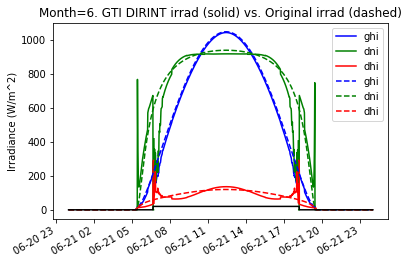

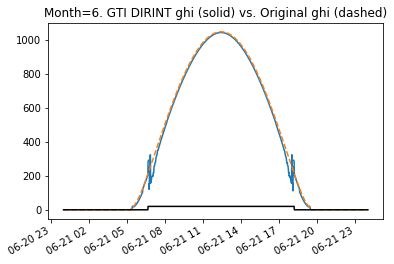

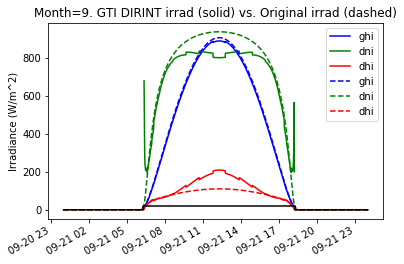

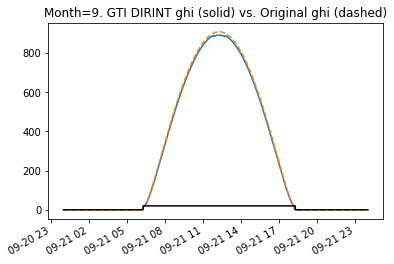

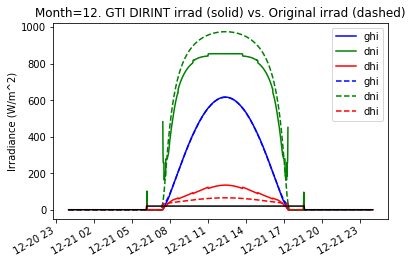

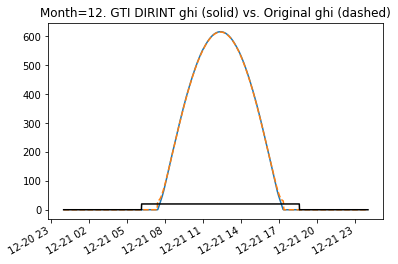

In [28]:
for month, data in gti_dirint_out.groupby(times.month):
    fig, ax = plt.subplots()
    data.plot(ax=ax, color=color)
    cs.loc[data.index].plot(ax=ax, ls='--', color=color)
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')  # please excuse the sloppy reuse of the axis
    ax.set_ylabel('Irradiance (W/m^2)')
    ax.set_title('Month={}. GTI DIRINT irrad (solid) vs. Original irrad (dashed)'.format(month))

    fig, ax = plt.subplots()
    data['ghi'].plot(ax=ax)
    cs.loc[data.index]['ghi'].plot(ax=ax, ls='--')
    (aoi_lt_90 * 20).loc[data.index].plot(color='k')
    ax.set_title('Month={}. GTI DIRINT ghi (solid) vs. Original ghi (dashed)'.format(month))